In [1]:
using RemoteREPL
if !isdefined(Base, :task)
	task = @async serve_repl()
end

Task (runnable) @0x000000000cdd9560

In [2]:
using Dates, DataFrames, Plots, PlotThemes
theme(:dracula)
plotlyjs()
using Unitful, Latexify, Optim
using PhysicalConstants.CODATA2018: g_n

┌ Info: REPL client opened a connection
│   peer = (ip"127.0.0.1", 0xd8cb)
└ @ RemoteREPL C:\Users\torfi\.julia\packages\RemoteREPL\tVFcu\src\server.jl:273


In [3]:
sitestr = read(download("https://www.landsvirkjun.is/rennsli-um-yfirfall-halslons"), String)
arrReg = r"\[(\[\d+,\d*[.]*\d*\][,\]])+"
nameReg = r"""\u005C"name\u005C":\u005C"(\w*\s\d*)*\u005C".\u005C"data\u005C":"""

datas = [sitestr[i] for i in findall(arrReg, sitestr)]
datas = [
	replace(i[2:end-1], "],[" => ";","," => " ")
	for i in datas
]
datas = eval.(Meta.parse.(datas))
names = [sitestr[i][end-15:end-12] for i in findall(nameReg, sitestr)]
# OH MY GOD THIS IS SO EASY!!!!!!!!

5-element Vector{String}:
 "2022"
 "2021"
 "2020"
 "2019"
 "2018"

In [4]:

datas[1] = vcat(datas[1], zeros(11,2))
datas[1][:,1] = cumsum(vcat(datas[1][1],ones(122)*diff(datas[1][:,1])[1]))
datas = hcat(datas...)

123×10 Matrix{Float64}:
 1.65663e12  0.0  1.65663e12  0.0  …  1.65663e12  0.0  1.65663e12  0.0
 1.65672e12  0.0  1.65672e12  0.0     1.65672e12  0.0  1.65672e12  0.0
 1.65681e12  0.0  1.65681e12  0.0     1.65681e12  0.0  1.65681e12  0.0
 1.65689e12  0.0  1.65689e12  0.0     1.65689e12  0.0  1.65689e12  0.0
 1.65698e12  0.0  1.65698e12  0.0     1.65698e12  0.0  1.65698e12  0.0
 1.65707e12  0.0  1.65707e12  0.0  …  1.65707e12  0.0  1.65707e12  0.0
 1.65715e12  0.0  1.65715e12  0.0     1.65715e12  0.0  1.65715e12  0.0
 1.65724e12  0.0  1.65724e12  0.0     1.65724e12  0.0  1.65724e12  0.0
 1.65732e12  0.0  1.65732e12  0.0     1.65732e12  0.0  1.65732e12  0.0
 1.65741e12  0.0  1.65741e12  0.0     1.65741e12  0.0  1.65741e12  0.0
 ⋮                                 ⋱                               
 1.66648e12  0.0  1.66648e12  0.0     1.66648e12  0.0  1.66648e12  0.0
 1.66657e12  0.0  1.66657e12  0.0  …  1.66657e12  0.0  1.66657e12  0.0
 1.66666e12  0.0  1.66666e12  0.0     1.66666e12  0.0  1

In [5]:
dates = [names[i] .* " Date" for i in eachindex(names)]
volsecs = [names[i] .* " volsecs" for i in eachindex(names)]
namess = Vector{String}(undef, 10)
for i in eachindex(namess)
	namess[i] = i % 2 == 0 ? volsecs[i÷2] : dates[i÷2+1]
end
dates = nothing
volsecs = nothing
datas = DataFrame(datas, namess)

,2022 Date,2022 volsecs,2021 Date,2021 volsecs,2020 Date,2020 volsecs,2019 Date
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.65663e12,0.0,1.65663e12,0.0,1.65663e12,0.0,1.65663e12
2,1.65672e12,0.0,1.65672e12,0.0,1.65672e12,0.0,1.65672e12
3,1.65681e12,0.0,1.65681e12,0.0,1.65681e12,0.0,1.65681e12
4,1.65689e12,0.0,1.65689e12,0.0,1.65689e12,0.0,1.65689e12
5,1.65698e12,0.0,1.65698e12,0.0,1.65698e12,0.0,1.65698e12
6,1.65707e12,0.0,1.65707e12,0.0,1.65707e12,0.0,1.65707e12
7,1.65715e12,0.0,1.65715e12,0.0,1.65715e12,0.0,1.65715e12
8,1.65724e12,0.0,1.65724e12,0.0,1.65724e12,0.0,1.65724e12
9,1.65732e12,0.0,1.65732e12,0.0,1.65732e12,0.0,1.65732e12


In [6]:
n = length(datas[1,:])
for i in eachindex(datas[1, 1:2:10])
	datas[!,i] = unix2datetime.(datas[!,i]./1000)
end
datas[!,2:2:n] = datas[!,2:2:n] .* 1u"m^3 * s^-1"

,2022 volsecs,2021 volsecs,2020 volsecs,2019 volsecs,2018 volsecs
,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
2,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
3,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
4,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
5,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
6,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
7,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
8,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1
9,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1,0.0 m^3 s^-1


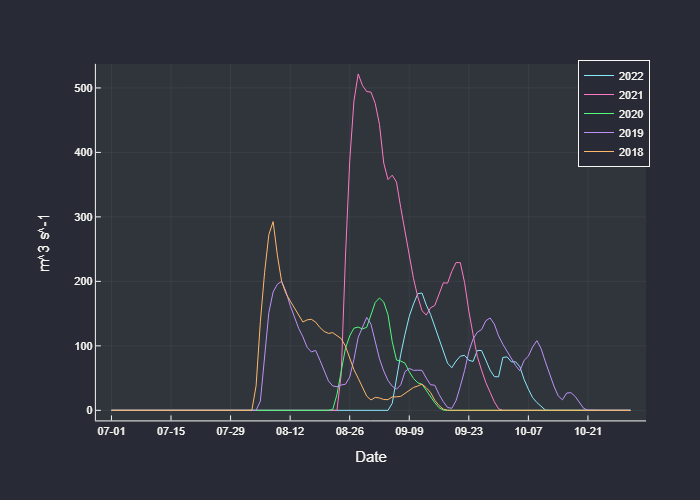

In [7]:

# I HATE DATES!
trunc(s) = s[end-4:end]
xTicks = (datas[1,1]:Day(14):datas[end,1], trunc.(string.(Date(datas[1,1]):Day(14):Date(datas[end,1]))))
p = plot(Matrix(datas[!,1:2:n]), Matrix(datas[!,2:2:n]),
	minorticks = 14,
	xticks = xTicks,
	labels = reshape(names, 1,5),
	xlabel = "Date",
)

In [8]:
tots = [sum(diff(datas[:,i-1]) .* datas[:,i][2:end]) for i in 2:2:10]

5-element Vector{Quantity{Float64, 𝐋^3, Unitful.FreeUnits{(m^3, ms, s^-1), 𝐋^3, nothing}}}:
  2.6352864e11 m^3 ms s^-1
 8.07130656e11 m^3 ms s^-1
 1.90819584e11 m^3 ms s^-1
 5.17209408e11 m^3 ms s^-1
  3.5348832e11 m^3 ms s^-1

In [9]:
latexify(:(f=0.25/log10(k/3.7D+5.74/Re^0.9)^2), env=:eq)

L"\begin{equation}
f = \frac{0.25}{\left( \log_{10}\left( \frac{k}{3.7 \cdot D} + \frac{5.74}{Re^{0.9}} \right) \right)^{2}}
\end{equation}
"

In [10]:
latexify(:(h = f * (L/D) * (U^2/2g)), env=:eq)

L"\begin{equation}
h = f \cdot \frac{L}{D} \cdot \frac{U^{2}}{2 \cdot g}
\end{equation}
"

In [11]:
Δh = (600-38)u"m"
k = 0.025u"mm"

r = 13u"m"
L = 42_500u"m"
Vp = L*2π*r^2
F = datas[:,2:2:n] .*(60*60*24)u"s"

A = F ./ Vp .* 2π .* r^2
function calcthet(A,r)
	wpfun(x) = abs(x-sin(x)/2 - A/r^2)
	optimize(wpfun, 0,2π).minimizer
end
wp = calcthet.(A,r) .* u"m"

,2022 volsecs,2021 volsecs,2020 volsecs,2019 volsecs,2018 volsecs
,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
2,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
3,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
4,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
5,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
6,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
7,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
8,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m
9,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m,2.86269e-16 m


In [12]:
U = sqrt(g_n*Δh*2)/2
D = 4*2π*r^2 ./ wp
v = 1e-3u"N*s/m^2"/1e3u"kg/m^3"
Re = U .* D ./v

f=0.25 ./ log10.(k ./ (3.7 .* D) .+ 5.74 ./ Re .^ 0.9) .^ 2
h=f .* L ./ D .* U.^2 ./ 2g_n

,2022 volsecs,2021 volsecs,2020 volsecs,2019 volsecs,2018 volsecs
,Quantity…,Quantity…,Quantity…,Quantity…,Quantity…
1,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
2,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
3,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
4,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
5,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
6,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
7,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
8,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m
9,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m,1.83878e-16 m


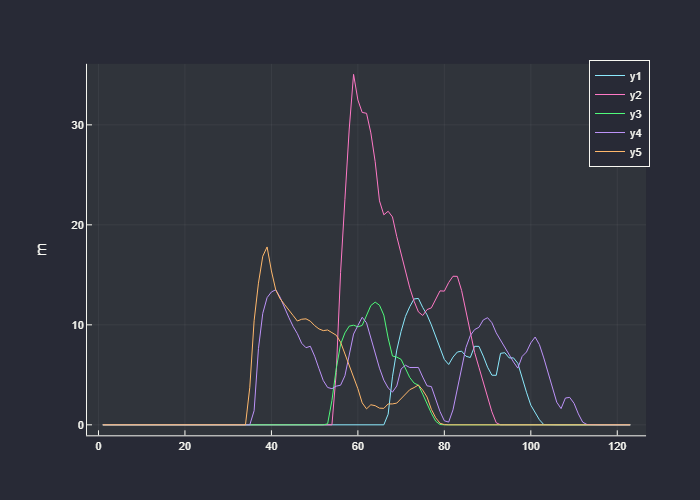

In [13]:
plot(Matrix(h))